# Character Recognition using CNN

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import the necessary libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
import imutils
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math
from sklearn.metrics import f1_score

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import optimizers

from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Input, Dropout
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

## Load the image

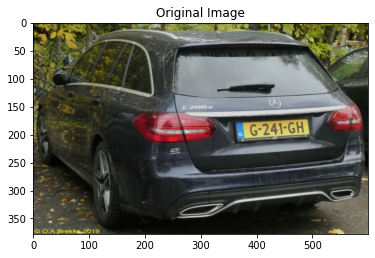

In [ ]:
# Read the image file
image = cv2.imread('test_dataset/images/25.jpg')
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.show()

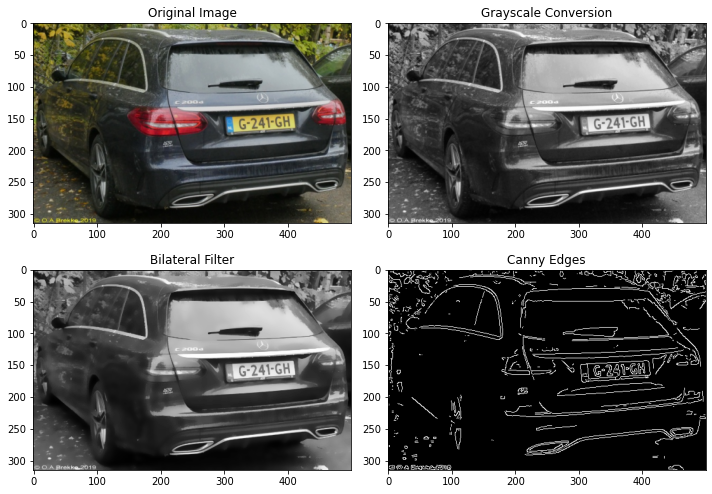

In [ ]:
image = imutils.resize(image, width=500)
img=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the original image
fig, ax = plt.subplots(2, 2, figsize=(10,7))
ax[0,0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax[0,0].set_title('Original Image')

# RGB to Gray scale conversion
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
ax[0,1].imshow(gray, cmap='gray')
ax[0,1].set_title('Grayscale Conversion')

# Noise removal with iterative bilateral filter(removes noise while preserving edges)
gray = cv2.bilateralFilter(gray, 11, 17, 17)
ax[1,0].imshow(gray, cmap='gray')
ax[1,0].set_title('Bilateral Filter')

# Find Edges of the grayscale image
edged = cv2.Canny(gray, 170, 200)
ax[1,1].imshow(edged, cmap='gray')
ax[1,1].set_title('Canny Edges')

fig.tight_layout()
plt.show()

# Find contours based on Edges
cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[0]
cnts=sorted(cnts, key = cv2.contourArea, reverse = True)[:30] #sort contours based on their area keeping minimum required area as '30' (anything smaller than this will not be considered)
NumberPlateCnt = None #we currently have no Number plate contour

# loop over our contours to find the best possible approximate contour of number plate
count = 0
for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        if len(approx) == 4:  # Select the contour with 4 corners
            NumberPlateCnt = approx #This is our approx Number Plate Contour
            x,y,w,h = cv2.boundingRect(c)
            ROI = img[y:y+h, x:x+w]
            break

if NumberPlateCnt is not None:
    # Drawing the selected contour on the original image
    cv2.drawContours(image, [NumberPlateCnt], -1, (0,255,0), 3)

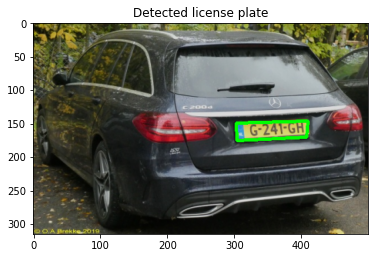

In [ ]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Detected license plate")
plt.show()

The green bounding box shows the detected license plate.

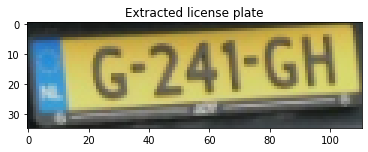

In [ ]:
# Find bounding box and extract ROI
plt.imshow(ROI)
plt.title("Extracted license plate")
plt.show()

In [ ]:
print(NumberPlateCnt)

[[[410 146]]

 [[303 149]]

 [[304 175]]

 [[408 170]]]


In [ ]:
# Distance between (x1, y1) and (x2, y2)
def dist(x1, x2, y1, y2):
    return ((x1-x2)**2+(y1-y2)**2)**0.5

In [ ]:
idx=0
m=0
# To find the index of coordinate with maximum y-coordinate
for i in range(4):
    if NumberPlateCnt[i][0][1]>m:
        idx=i
        m=NumberPlateCnt[i][0][1]

# Assign index to the previous coordinate
if idx==0:
    pin=3
else:
    pin=idx-1

# Assign index to the next coordinate
if idx==3:
    nin=0
else:
    nin=idx+1

# Find distances between the acquired coordinate and its previous and next coordinate
p=dist(NumberPlateCnt[idx][0][0], NumberPlateCnt[pin][0][0], NumberPlateCnt[idx][0][1], NumberPlateCnt[pin][0][1])
n=dist(NumberPlateCnt[idx][0][0], NumberPlateCnt[nin][0][0], NumberPlateCnt[idx][0][1], NumberPlateCnt[nin][0][1])

# The coordinate that has more distance from the acquired coordinate is the required second bottom-most coordinate
if p>n:
    if NumberPlateCnt[pin][0][0]<NumberPlateCnt[idx][0][0]:
        left=pin
        right=idx
    else:
        left=idx
        right=pin
    d=p
else:
    if NumberPlateCnt[nin][0][0]<NumberPlateCnt[idx][0][0]:
        left=nin
        right=idx
    else:
        left=idx
        right=nin
    d=n
print(left, right)

2 3


In [ ]:
left_x=NumberPlateCnt[left][0][0]
left_y=NumberPlateCnt[left][0][1]
right_x=NumberPlateCnt[right][0][0]
right_y=NumberPlateCnt[right][0][1]
print(left_x, left_y, right_x, right_y)

304 175 408 170


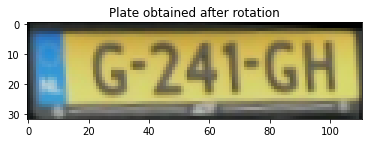

In [ ]:
# Finding the angle of rotation by calculating sin of theta
opp=right_y-left_y
hyp=((left_x-right_x)**2+(left_y-right_y)**2)**0.5
sin=opp/hyp
theta=math.asin(sin)*57.2958

# Rotate the image according to the angle of rotation obtained
image_center = tuple(np.array(ROI.shape[1::-1]) / 2)
rot_mat = cv2.getRotationMatrix2D(image_center, theta, 1.0)
result = cv2.warpAffine(ROI, rot_mat, ROI.shape[1::-1], flags=cv2.INTER_LINEAR)

# The image can be cropped after rotation( since rotated image takes much more height)
if opp>0:
    h=result.shape[0]-opp//2
else:
    h=result.shape[0]+opp//2

result=result[0:h, :]
plt.imshow(result)
plt.title("Plate obtained after rotation")
plt.show()

In [ ]:
# Match contours to license plate or character template
def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')
            plt.title('Predict Segments')

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) # List that stores the character's binary image (unsorted)
            
    # Return characters on ascending order with respect to the x-coordinate (most-left character first)
            
    plt.show()
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

In [ ]:
# Find characters in the resulting images
def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.title('Contour')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

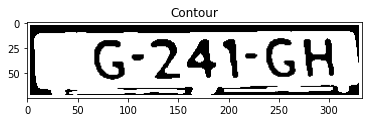

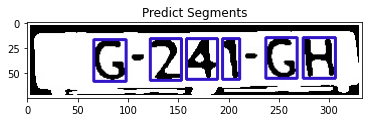

In [ ]:
char=segment_characters(result)

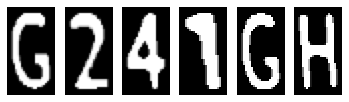

In [ ]:
for i in range(len(char)):
    plt.subplot(1, len(char), i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')
plt.show()

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
path = 'data'
train_generator = train_datagen.flow_from_directory(
        path+'/train',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28
        batch_size=1,
        class_mode='sparse')

validation_generator = train_datagen.flow_from_directory(
        path+'/val',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28 batch_size=1,
        class_mode='sparse')

Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.


In [ ]:
K.clear_session()
model = Sequential()
model.add(Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(lr=0.0001), metrics='accuracy')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        23248     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        131104    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        131136    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        65600     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0

In [ ]:
batch_size = 1
result = model.fit(
      train_generator,
      steps_per_epoch = train_generator.samples // batch_size,
      validation_data = validation_generator, 
      epochs = 25, verbose=1, callbacks=None)

Epoch 1/25
864/864 [==============================] - 29s 34ms/step - loss: 3.0946 - accuracy: 0.1481 - val_loss: 1.8412 - val_accuracy: 0.4815
Epoch 2/25
864/864 [==============================] - 30s 34ms/step - loss: 1.2811 - accuracy: 0.6215 - val_loss: 0.7097 - val_accuracy: 0.7917
Epoch 3/25
864/864 [==============================] - 29s 34ms/step - loss: 0.6662 - accuracy: 0.7963 - val_loss: 0.3646 - val_accuracy: 0.9028
Epoch 4/25
864/864 [==============================] - 29s 34ms/step - loss: 0.4417 - accuracy: 0.8634 - val_loss: 0.2511 - val_accuracy: 0.8981
Epoch 5/25
864/864 [==============================] - 29s 34ms/step - loss: 0.2811 - accuracy: 0.9109 - val_loss: 0.1789 - val_accuracy: 0.9306
Epoch 6/25
864/864 [==============================] - 32s 37ms/step - loss: 0.2817 - accuracy: 0.9201 - val_loss: 0.2678 - val_accuracy: 0.9167
Epoch 7/25
864/864 [==============================] - 35s 40ms/step - loss: 0.2269 - accuracy: 0.9294 - val_loss: 0.0932 - val_accuracy:

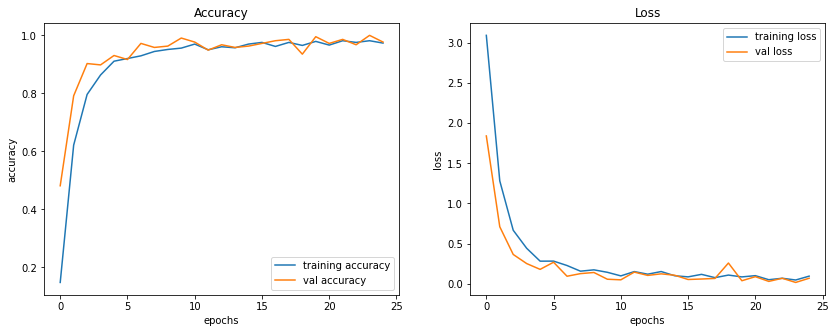

In [ ]:
fig = plt.figure(figsize=(14,5))
grid=gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[0])
plt.plot(result.history['accuracy'], label='training accuracy')
plt.plot(result.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

fig.add_subplot(grid[1])
plt.plot(result.history['loss'], label='training loss')
plt.plot(result.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

Save the model weights for future use.

In [ ]:
# Save the weights
model.save_weights('./checkpoints/my_checkpoint')

In [ ]:
# Create a new model instance
loaded_model = Sequential()
loaded_model.add(Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(Conv2D(32, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(Conv2D(64, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(Conv2D(64, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(MaxPooling2D(pool_size=(4, 4)))
loaded_model.add(Dropout(0.4))
loaded_model.add(Flatten())
loaded_model.add(Dense(128, activation='relu'))
loaded_model.add(Dense(36, activation='softmax'))

# Restore the weights
loaded_model.load_weights('checkpoints/my_checkpoint')

## Predict the license plate number

In [ ]:
# Predicting the output
def fix_dimension(img): 
    new_img = np.zeros((28,28,3))
    for i in range(3):
        new_img[:,:,i] = img
        return new_img
  
def show_results():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char): #iterating over the characters
        img_ = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3) #preparing image for the model
        y_ = loaded_model.predict_classes(img)[0] #predicting the class
        character = dic[y_]
        output.append(character) #storing the result in a list
        
    plate_number = ''.join(output)
    
    return plate_number

print(show_results())

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
G241GK


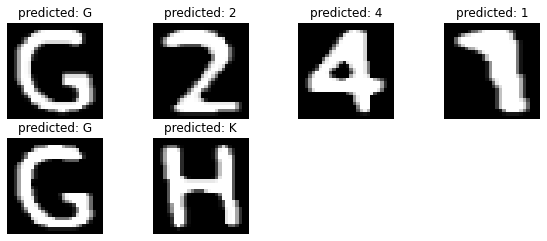

In [ ]:
# Segmented characters and their predicted value.
plt.figure(figsize=(10,6))
for i,ch in enumerate(char):
    img = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
    plt.subplot(3,4,i+1)
    plt.imshow(img,cmap='gray')
    plt.title(f'predicted: {show_results()[i]}')
    plt.axis('off')
plt.show()

## Importing the dataset

In [ ]:
labels=pd.read_excel('test_dataset/labels.xlsx')
labels['ID']=labels['ID'].map(str)
labels

ID       NUMBER
0      1    KL55R2473
1      2  GJW115A1138
2      3    KL16J3636
3      4   MH20EE7598
4      5      PJJ1L76
..   ...          ...
181  182      DHF5B15
182  183      DBJ5R59
183  184      LVY8X45
184  185      YYD6B61
185  186      CHI4A30

[186 rows x 2 columns]

## Accuracy

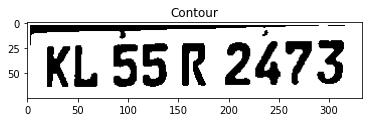

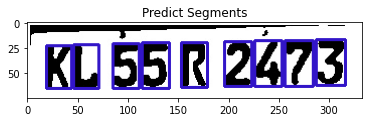

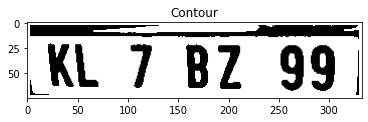

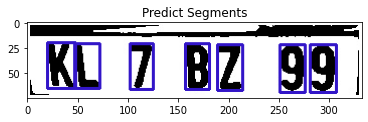

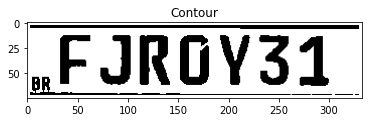

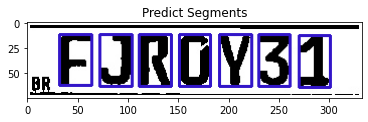

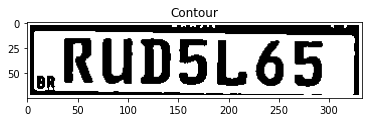

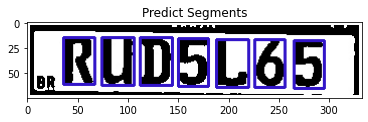

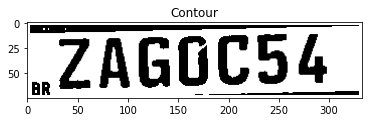

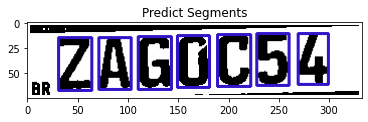

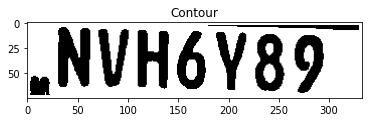

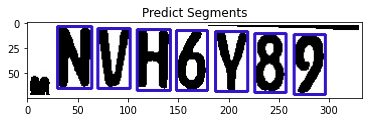

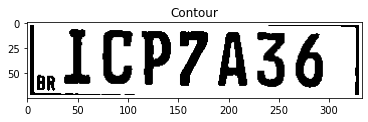

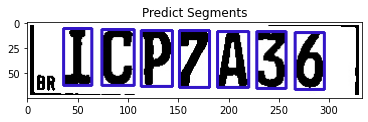

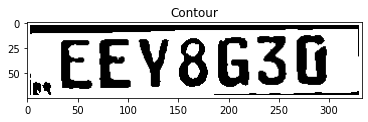

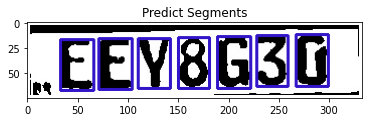

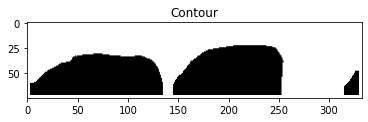

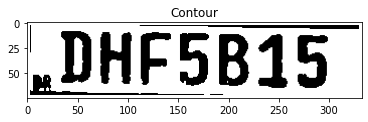

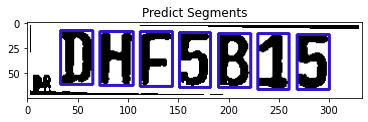

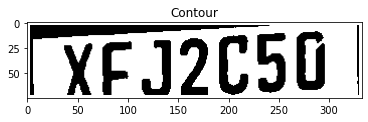

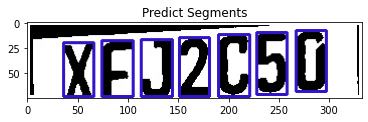

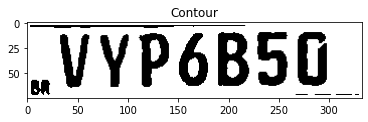

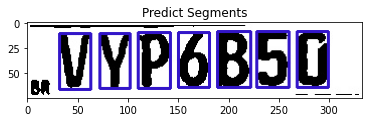

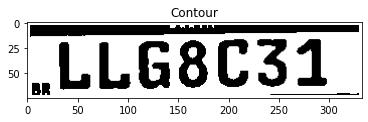

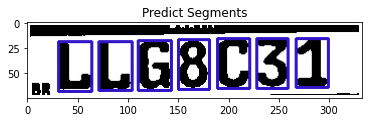

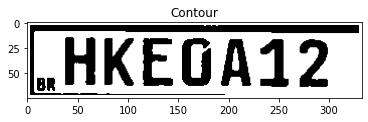

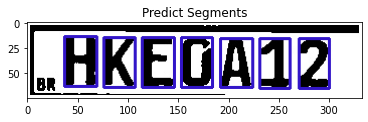

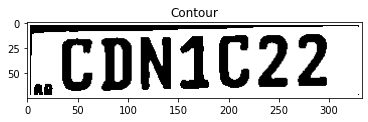

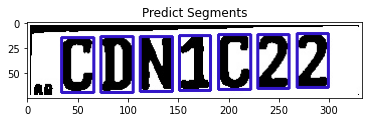

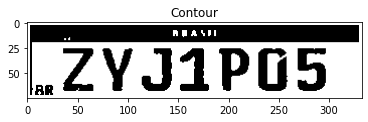

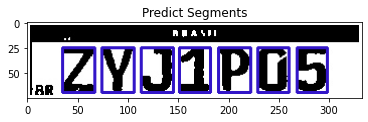

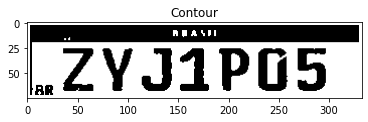

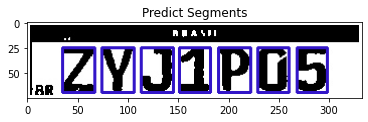

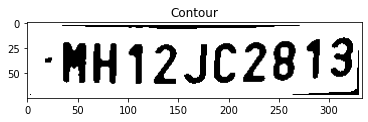

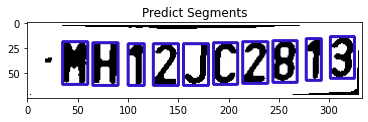

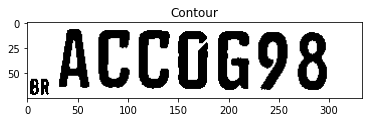

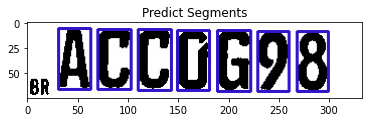

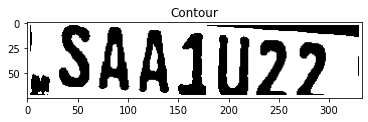

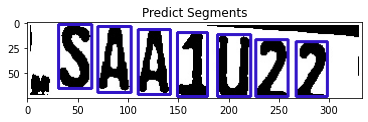

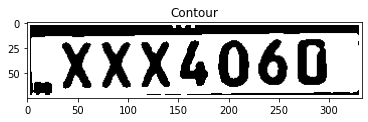

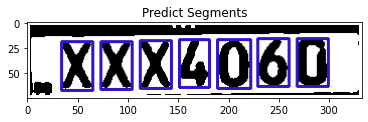

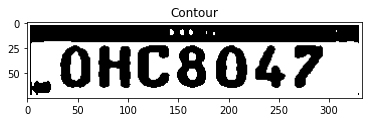

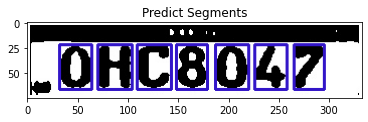

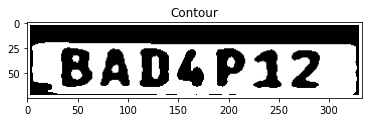

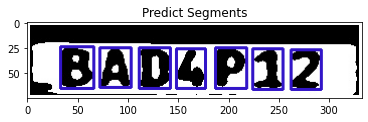

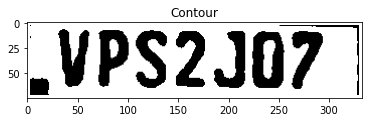

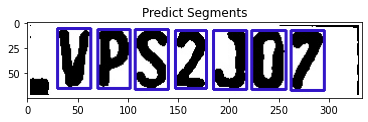

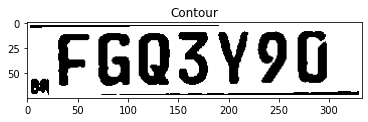

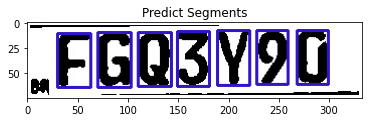

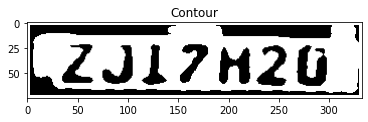

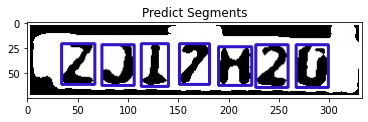

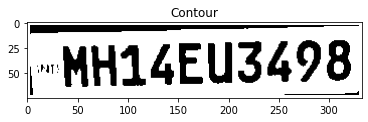

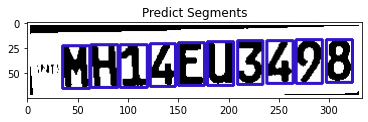

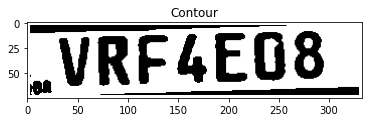

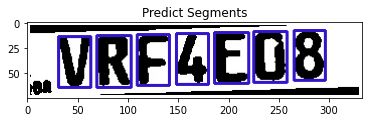

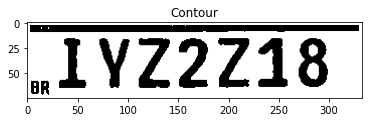

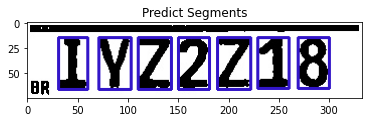

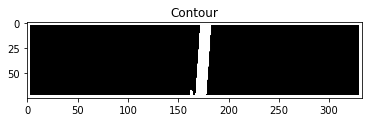

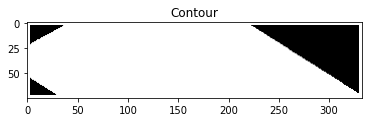

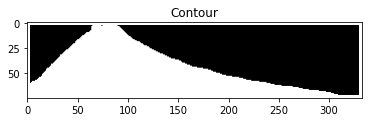

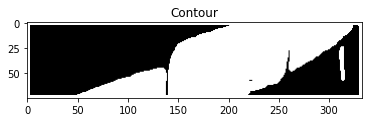

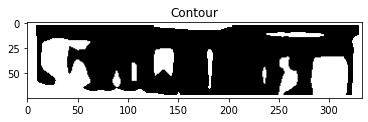

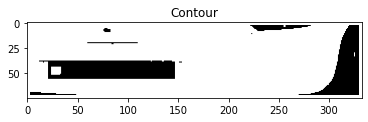

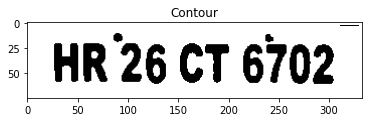

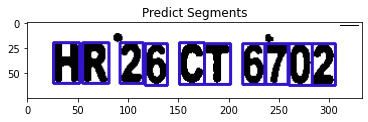

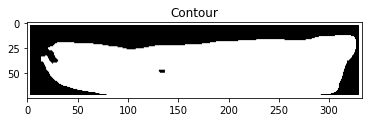

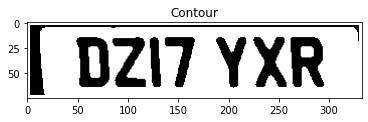

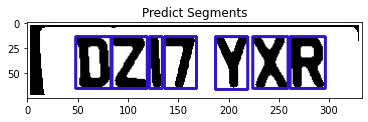

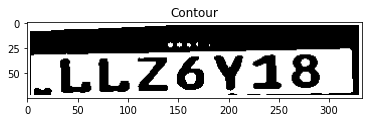

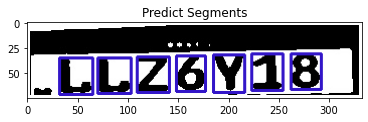

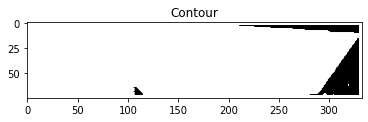

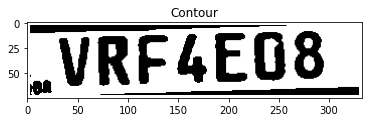

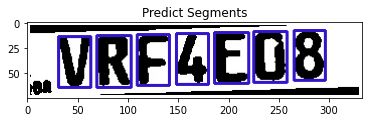

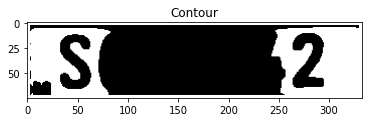

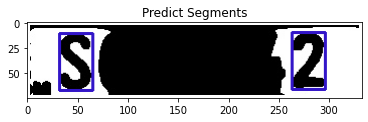

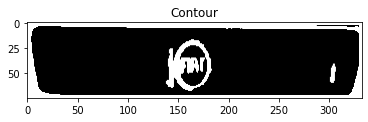

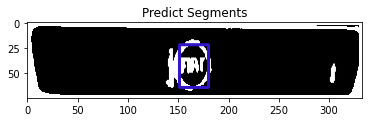

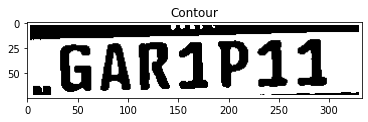

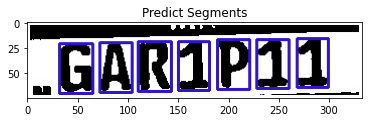

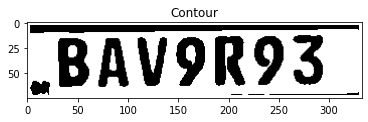

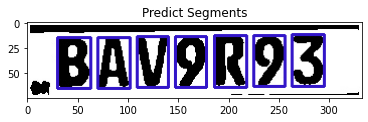

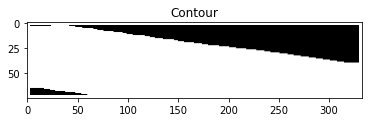

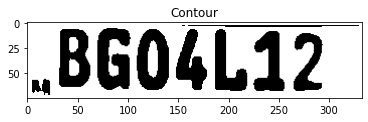

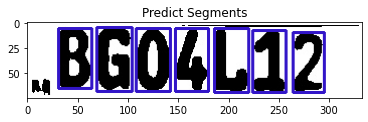

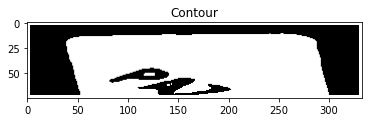

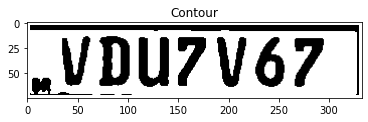

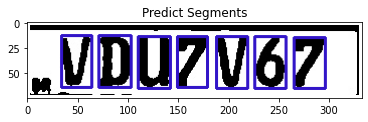

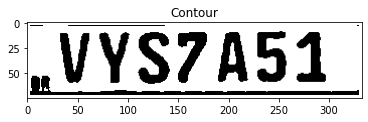

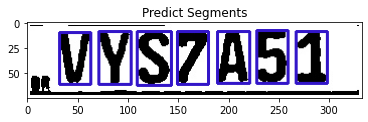

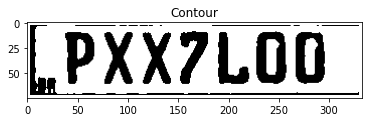

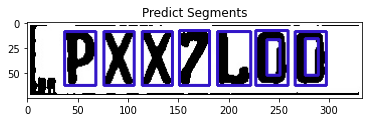

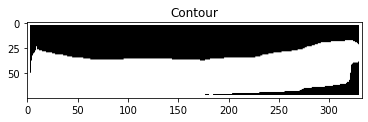

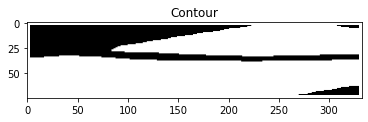

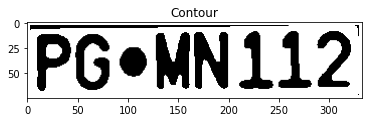

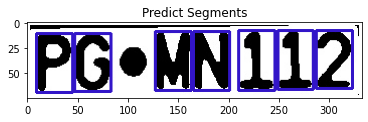

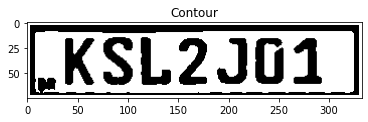

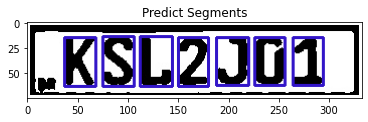

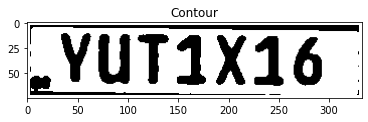

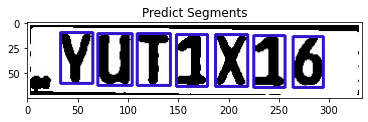

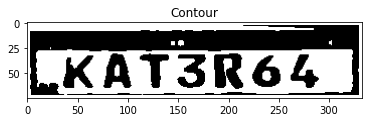

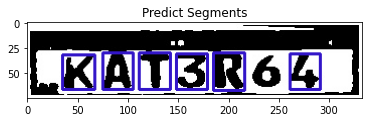

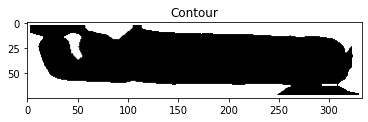

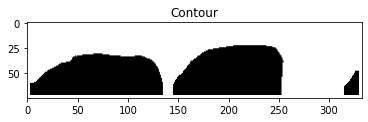

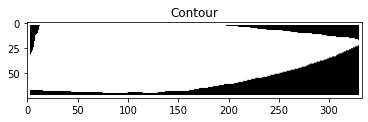

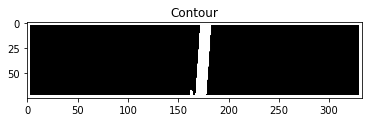

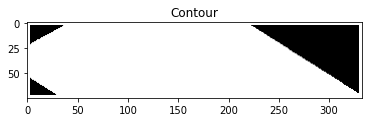

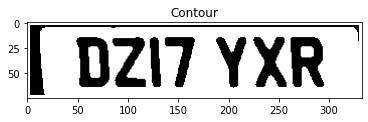

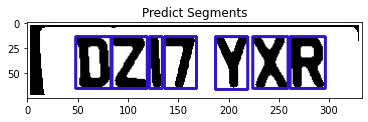

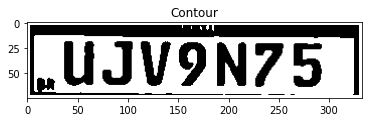

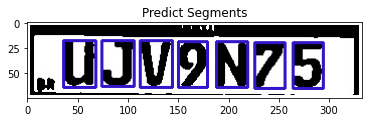

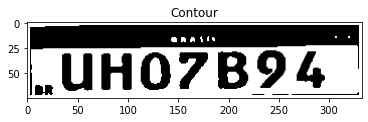

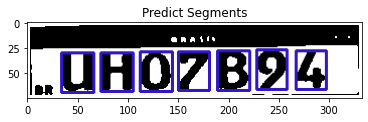

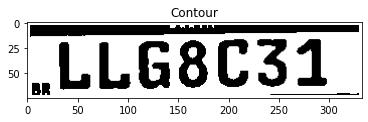

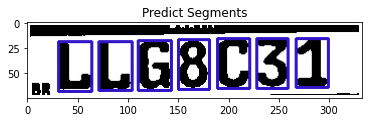

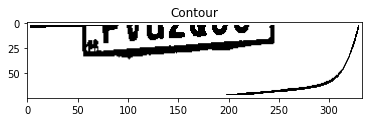

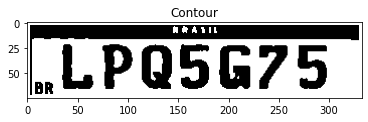

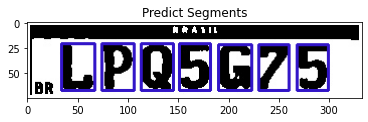

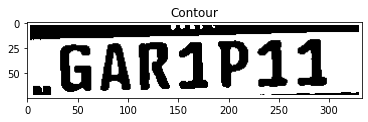

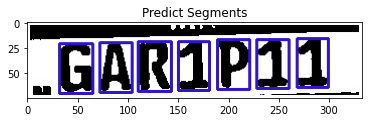

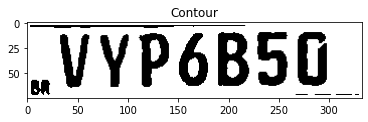

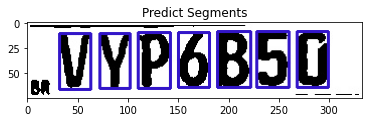

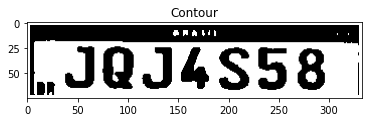

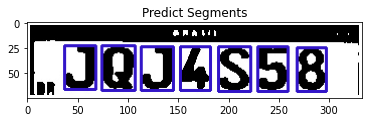

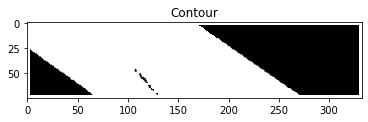

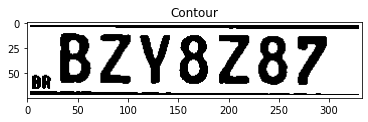

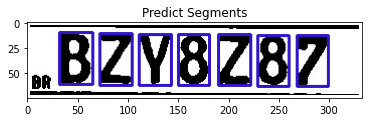

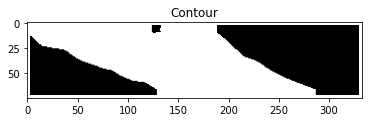

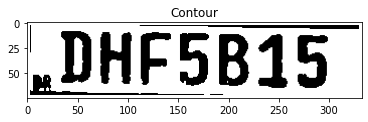

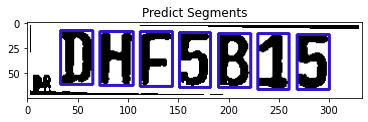

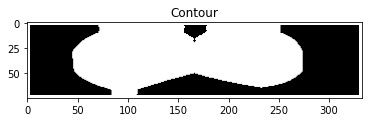

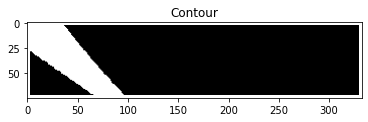

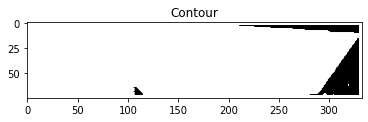

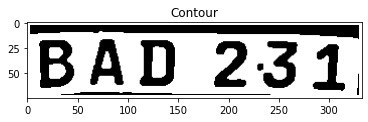

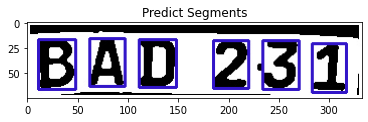

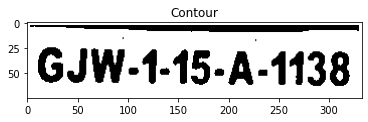

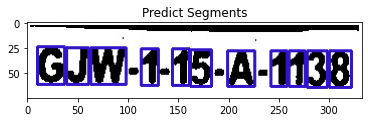

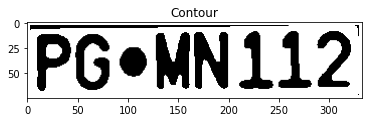

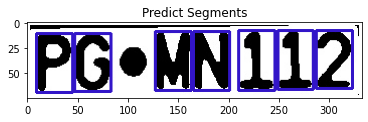

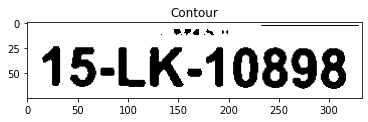

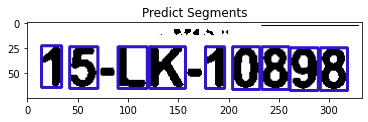

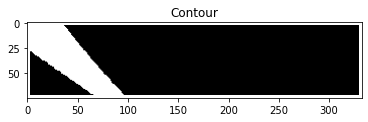

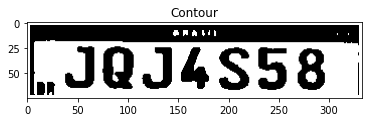

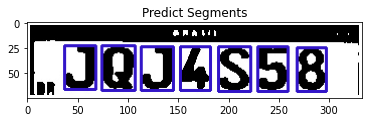

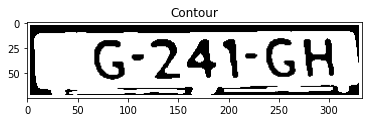

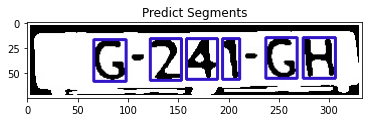

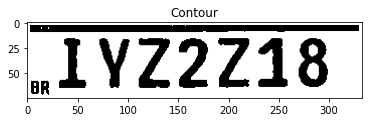

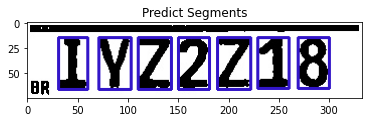

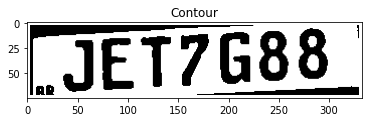

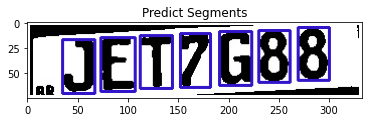

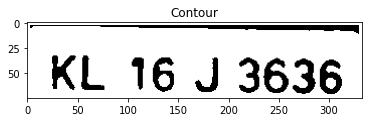

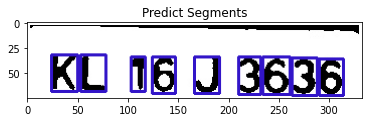

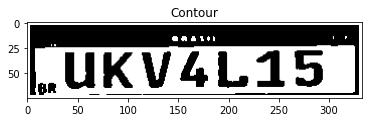

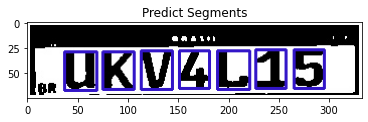

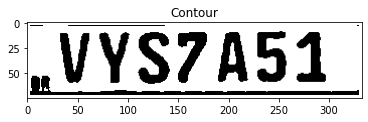

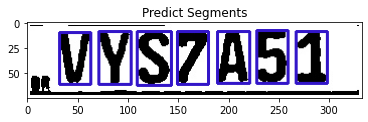

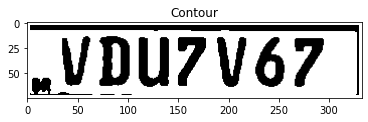

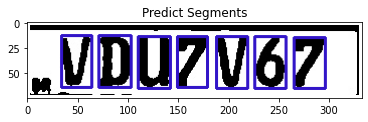

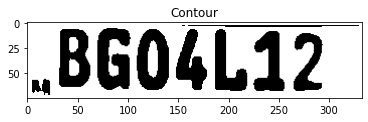

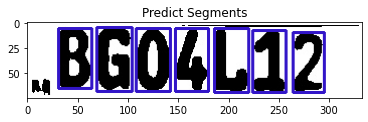

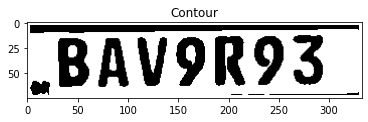

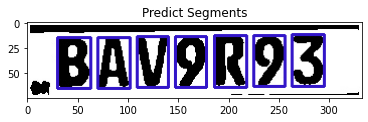

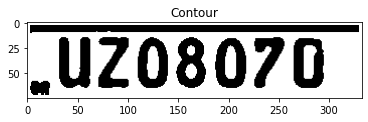

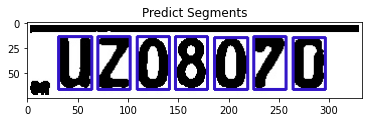

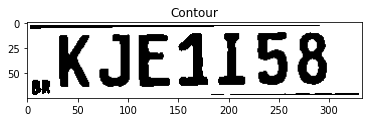

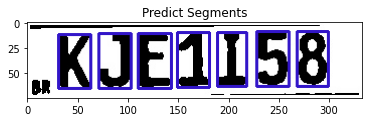

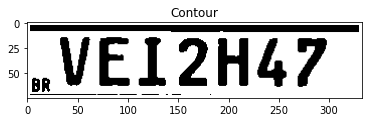

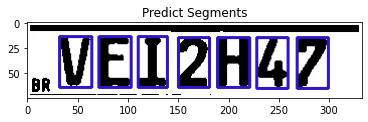

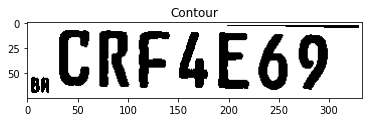

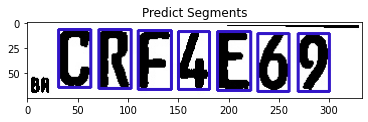

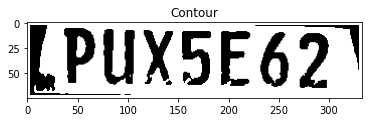

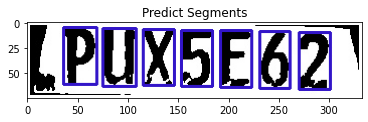

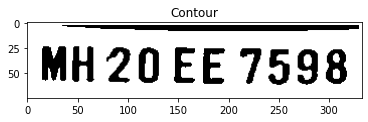

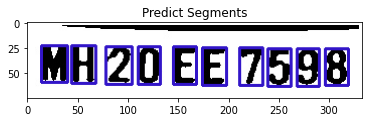

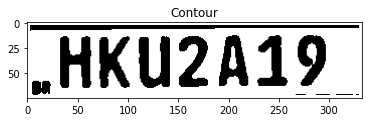

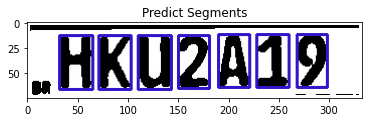

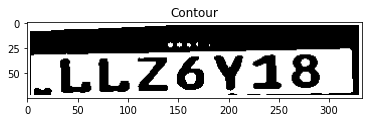

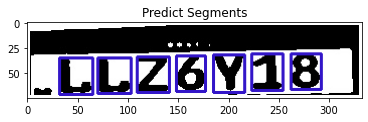

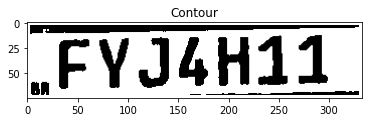

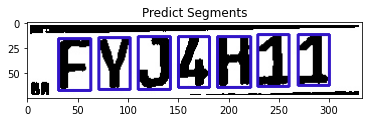

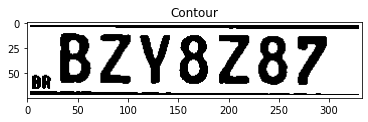

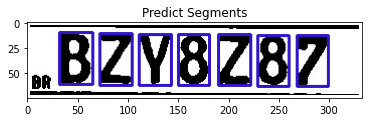

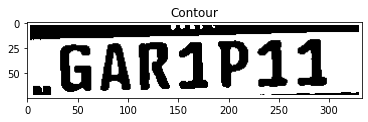

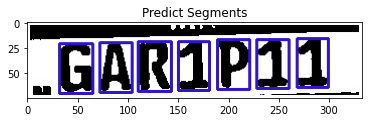

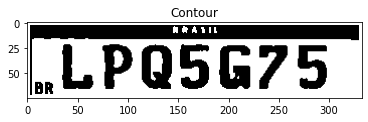

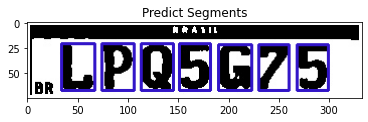

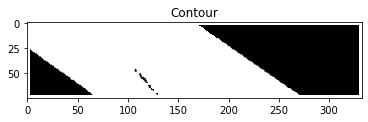

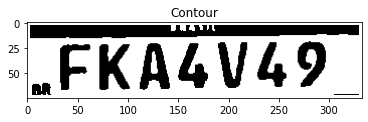

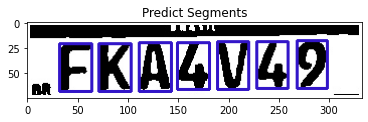

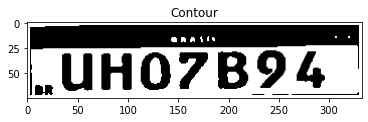

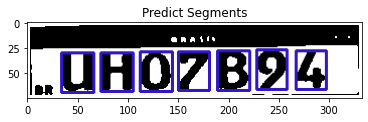

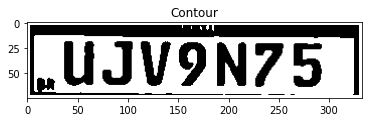

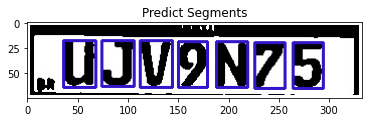

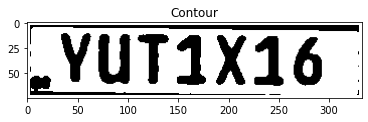

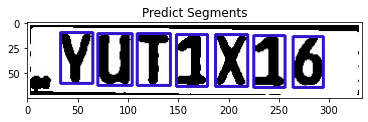

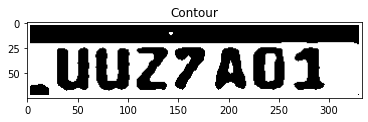

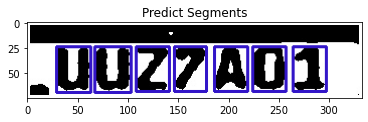

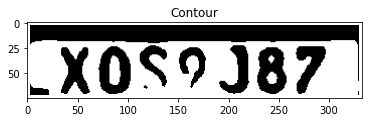

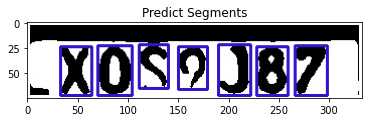

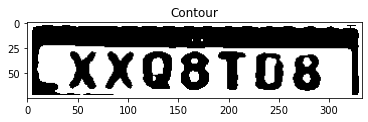

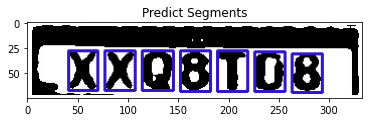

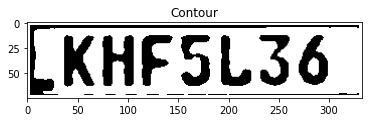

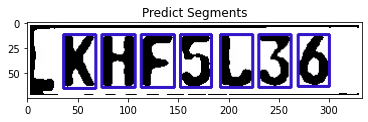

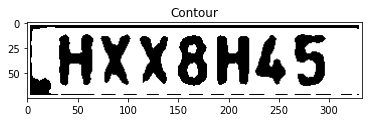

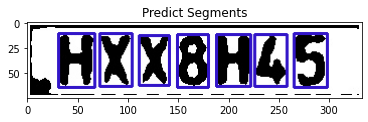

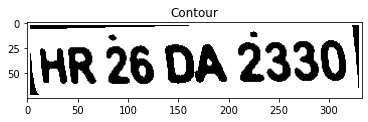

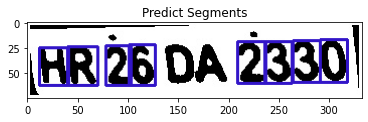

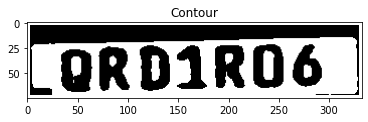

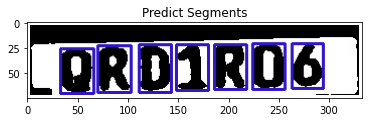

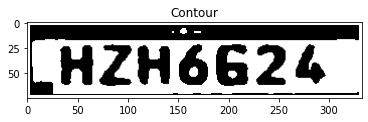

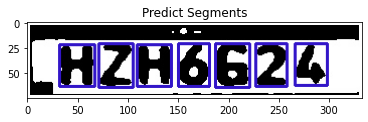

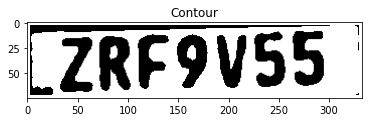

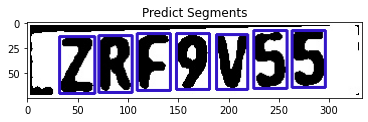

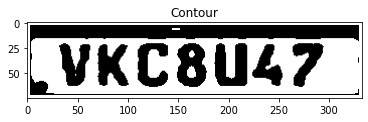

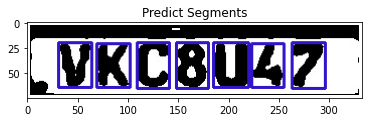

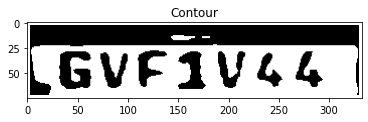

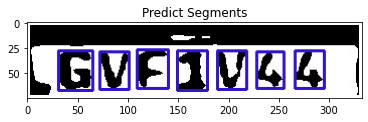

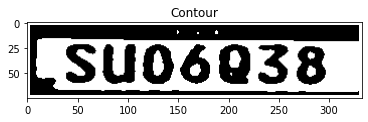

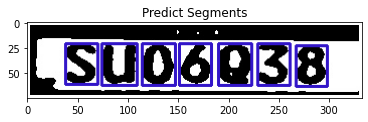

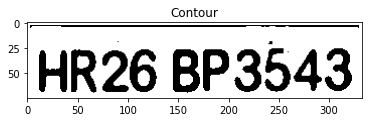

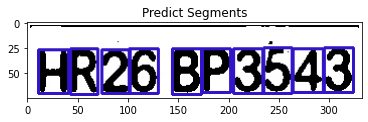

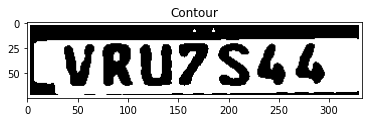

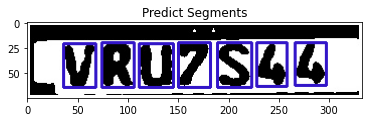

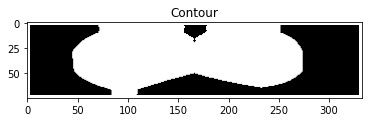

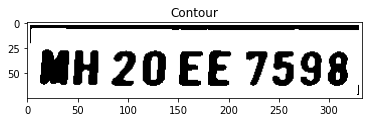

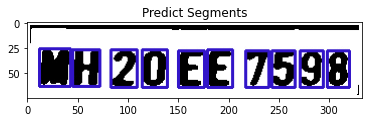

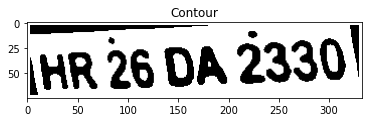

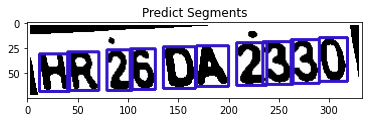

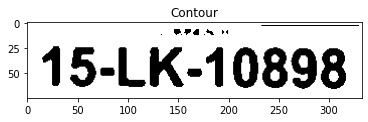

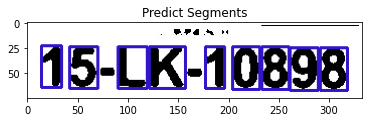

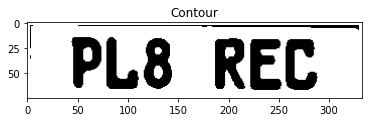

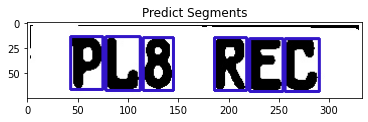

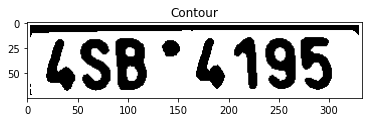

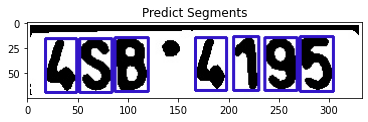

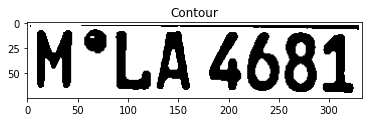

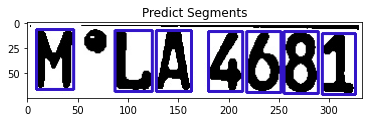

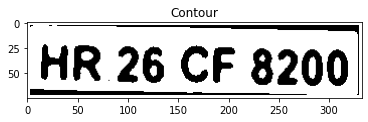

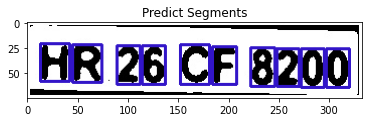

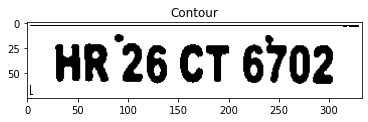

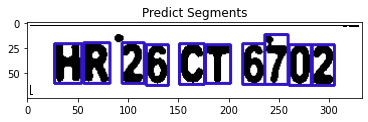

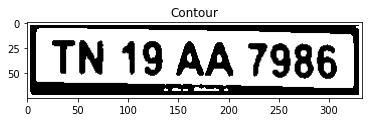

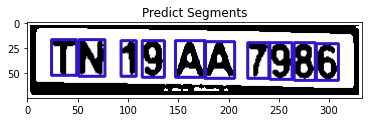

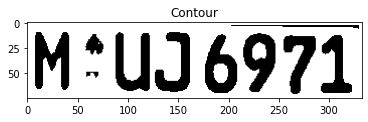

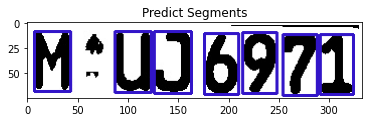

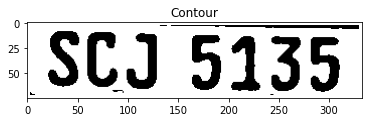

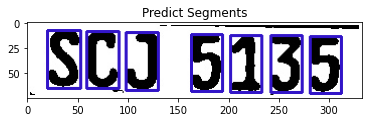

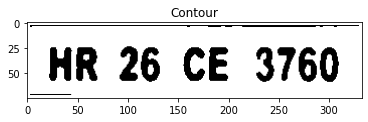

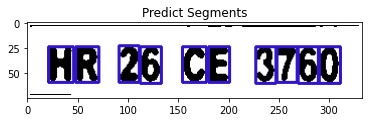

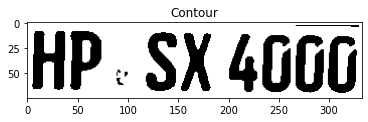

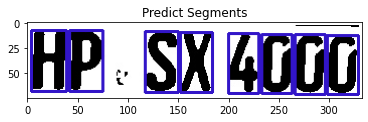

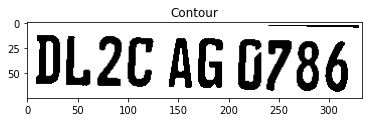

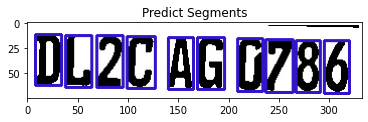

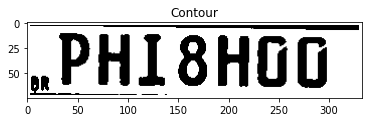

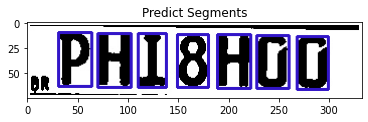

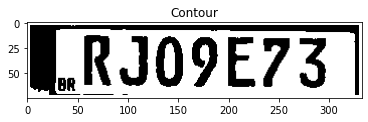

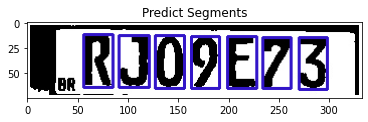

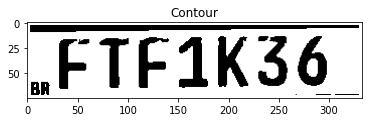

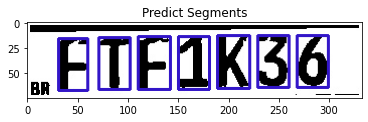

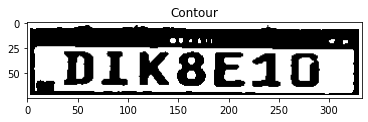

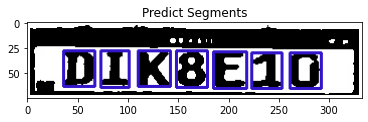

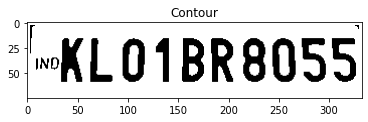

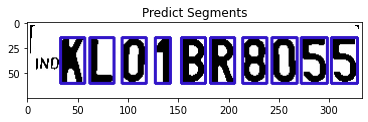

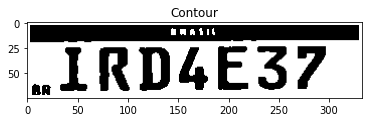

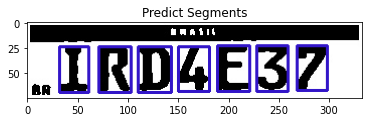

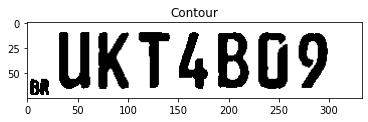

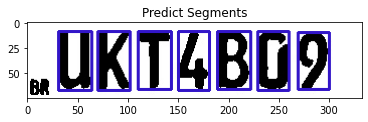

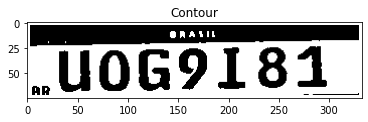

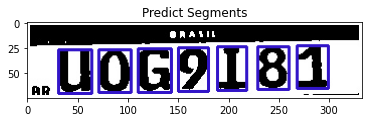

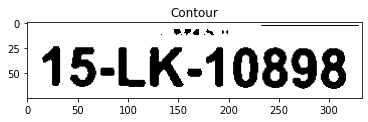

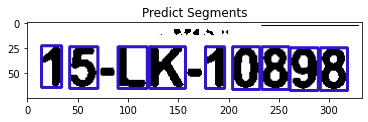

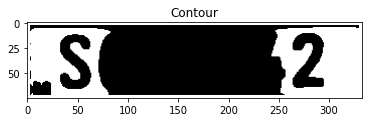

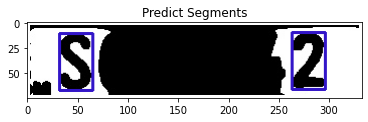

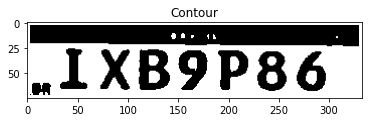

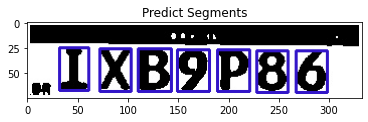

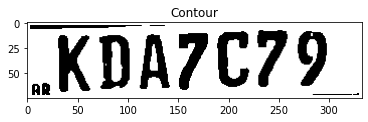

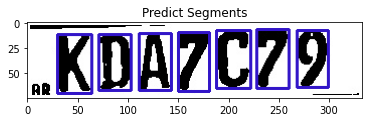

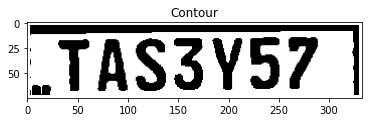

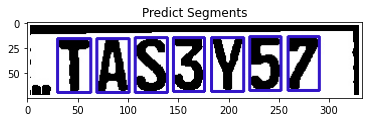

In [ ]:
file_list=os.listdir(r"test_dataset/images")
count=0
for path in file_list:
    no=path[:-4]
    row=labels['NUMBER'].where(labels['ID'] == no).dropna().values[0]
    image = cv2.imread('test_dataset/images/'+path)
    # Resize the image - change width to 500
    image = imutils.resize(image, width=500)
    img=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # RGB to Gray scale conversion
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Noise removal with iterative bilateral filter(removes noise while preserving edges)
    gray = cv2.bilateralFilter(gray, 11, 17, 17)

    # Find Edges of the grayscale image
    edged = cv2.Canny(gray, 170, 200)

    # Find contours based on Edges
    cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[0]
    cnts=sorted(cnts, key = cv2.contourArea, reverse = True)[:30] #sort contours based on their area keeping minimum required area as '30' (anything smaller than this will not be considered)
    NumberPlateCnt = None #we currently have no Number plate contour

    # loop over our contours to find the best possible approximate contour of number plate
    for c in cnts:
            peri = cv2.arcLength(c, True)
            approx = cv2.approxPolyDP(c, 0.02 * peri, True)
            if len(approx) == 4:  # Select the contour with 4 corners
                NumberPlateCnt = approx #This is our approx Number Plate Contour
                x,y,w,h = cv2.boundingRect(c)
                ROI = img[y:y+h, x:x+w]
                break

    idx=0
    m=0
    if NumberPlateCnt is None:
        continue
    for i in range(4):
        if NumberPlateCnt[i][0][1]>m:
            idx=i
            m=NumberPlateCnt[i][0][1]
    if idx==0:
        pin=3
    else:
        pin=idx-1
    if idx==3:
        nin=0
    else:
        nin=idx+1

    p=dist(NumberPlateCnt[idx][0][0], NumberPlateCnt[pin][0][0], NumberPlateCnt[idx][0][1], NumberPlateCnt[pin][0][1])
    n=dist(NumberPlateCnt[idx][0][0], NumberPlateCnt[nin][0][0], NumberPlateCnt[idx][0][1], NumberPlateCnt[nin][0][1])

    if p>n:
        if NumberPlateCnt[pin][0][0]<NumberPlateCnt[idx][0][0]:
            left=pin
            right=idx
        else:
            left=idx
            right=pin
        d=p
    else:
        if NumberPlateCnt[nin][0][0]<NumberPlateCnt[idx][0][0]:
            left=nin
            right=idx
        else:
            left=idx
            right=nin
        d=n
    left_x=NumberPlateCnt[left][0][0]
    left_y=NumberPlateCnt[left][0][1]
    right_x=NumberPlateCnt[right][0][0]
    right_y=NumberPlateCnt[right][0][1]

    opp=right_y-left_y
    hyp=((left_x-right_x)**2+(left_y-right_y)**2)**0.5
    sin=opp/hyp
    theta=math.asin(sin)*57.2958

    image_center = tuple(np.array(ROI.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, theta, 1.0)
    result = cv2.warpAffine(ROI, rot_mat, ROI.shape[1::-1], flags=cv2.INTER_LINEAR)

    if opp>0:
        h=result.shape[0]-opp//2
    else:
        h=result.shape[0]+opp//2

    result=result[0:h, :]
    char=segment_characters(result)
    #count=show_results(count)
#print("Accuracy: "+str((count/166)*100)+"%")

# License Plate Detection using YOLOv3

In [ ]:
from IPython.display import Image
from matplotlib import pyplot as plt

import cv2
import argparse
import sys
import numpy as np
import pandas as pd
import os.path

from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Input, Dropout
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

In [ ]:
input_path = r'test_dataset/images/1.jpg'

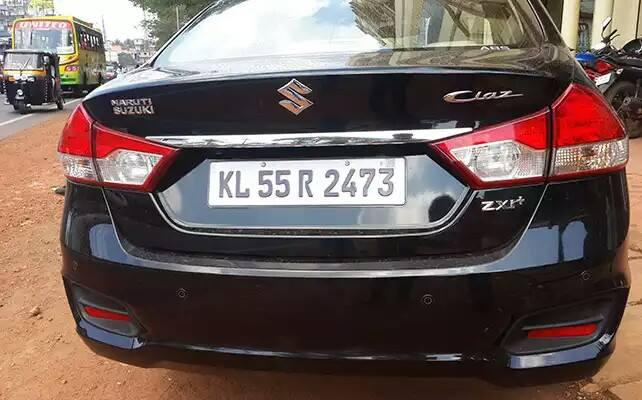

In [ ]:
Image(input_path)

In [ ]:
cap = cv2.VideoCapture(input_path)

In [ ]:
# Initialize the parameters

confThreshold = 0.5  #Confidence threshold
nmsThreshold = 0.4  #Non-maximum suppression threshold

inpWidth = 416     #Width of network's input image
inpHeight = 416     #Height of network's input image

In [ ]:
# Load names of classes
classesFile = "yolo_utils/classes.names";

In [ ]:
# Append all different classes into the list 'classes'
classes = None
with open(classesFile, 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')

In [ ]:
# Give the configuration and weight files for the model and load the network using them.
modelConfiguration = r"yolo_utils/darknet-yolov3.cfg";
modelWeights = r"yolo_utils/lapi.weights";

In [ ]:
net = cv2.dnn.readNetFromDarknet(modelConfiguration, modelWeights)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

In [ ]:
# Get the names of the output layers
def getOutputsNames(net):
    # Get the names of all the layers in the network
    layersNames = net.getLayerNames()
    # Get the names of the output layers, i.e. the layers with unconnected outputs
    return [layersNames[i[0] - 1] for i in net.getUnconnectedOutLayers()]

In [ ]:
# Draw the predicted bounding box
def drawPred(classId, conf, left, top, right, bottom, frame):
    # Draw a bounding box.
    cv2.rectangle(frame, (left, top), (right, bottom), (0, 255, 0), 3)

    label = '%.2f' % conf

    # Get the label for the class name and its confidence
    if classes:
        assert(classId < len(classes))
        label = '%s:%s' % (classes[classId], label)

    #Display the label at the top of the bounding box
    labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    top = max(top, labelSize[1])
    cv2.rectangle(frame, (left, top - round(1.5*labelSize[1])), (left + round(1.5*labelSize[0]), top + baseLine), (0, 0, 255), cv2.FILLED)
    #cv.rectangle(frame, (left, top - round(1.5*labelSize[1])), (left + round(1.5*labelSize[0]), top + baseLine),    (255, 255, 255), cv.FILLED)
    cv2.putText(frame, label, (left, top), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0,0,0), 2)

In [ ]:
# Remove the bounding boxes with low confidence using non-maxima suppression
def postprocess(frame, outs):
    frameHeight = frame.shape[0]
    frameWidth = frame.shape[1]
    
    # Scan through all the bounding boxes output from the network and keep only the
    # ones with high confidence scores. Assign the box's class label as the class with the highest score.
    classIds = []
    confidences = []
    boxes = []
    for out in outs:
        #print("out.shape : ", out.shape)
        for detection in out:
            #if detection[4]>0.001:
            scores = detection[5:]
            classId = np.argmax(scores)
            #if scores[classId]>confThreshold:
            confidence = scores[classId]
            '''if detection[4]>confThreshold:
                print(detection[4], " - ", scores[classId], " - th : ", confThreshold)
                print(detection)'''
            if confidence > confThreshold:
                center_x = int(detection[0] * frameWidth)
                center_y = int(detection[1] * frameHeight)
                width = int(detection[2] * frameWidth)
                height = int(detection[3] * frameHeight)
                left = int(center_x - width / 2)
                top = int(center_y - height / 2)
                classIds.append(classId)
                confidences.append(float(confidence))
                boxes.append([left, top, width, height])

    # Perform non maximum suppression to eliminate redundant overlapping boxes with lower confidences.
    cropped=None
    indices = cv2.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)
    for i in indices:
        i = i[0]
        box = boxes[i]
        left = box[0]
        top = box[1]
        width = box[2]
        height = box[3]
        
        # calculate bottom and right
        bottom = top + height
        right = left + width
        
        #crop the plate out
        cropped = frame[top:bottom, left:right].copy()
        # drawPred
        drawPred(classIds[i], confidences[i], left, top, right, bottom, frame)
    if cropped is not None:
        return cropped

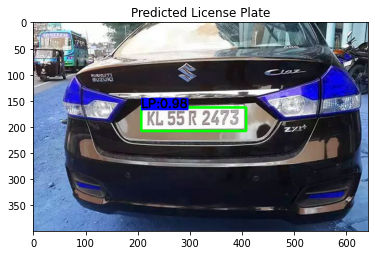

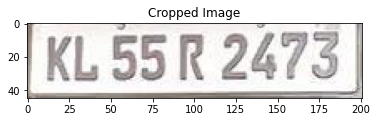

Done processing !!!


In [ ]:
while cv2.waitKey(1) < 0:

    hasFrame, frame = cap.read() #frame: an image object from cv2

    # Stop the program if reached end of video
    if not hasFrame:
        print("Done processing !!!")
        break

    # Create a 4D blob from a frame.
    blob = cv2.dnn.blobFromImage(frame, 1/255, (inpWidth, inpHeight), [0,0,0], 1, crop=False)

    # Sets the input to the network
    net.setInput(blob)

    # Runs the forward pass to get output of the output layers
    outs = net.forward(getOutputsNames(net))

    # Remove the bounding boxes with low confidence
    cropped = postprocess(frame, outs)

    plt.imshow(frame)
    plt.title("Predicted License Plate")
    plt.show()
    plt.imshow(cropped)
    plt.title("Cropped Image")
    plt.show()

# Character Segmentation

In [ ]:
# Match contours to license plate or character template
def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)
            plt.imshow(ii, cmap='gray')
            plt.title('Predict Segments')

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) # List that stores the character's binary image (unsorted)
            
    # Return characters on ascending order with respect to the x-coordinate (most-left character first)
            
    plt.show()
    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

In [ ]:
# Find characters in the resulting images
def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    plt.imshow(img_binary_lp, cmap='gray')
    plt.title('Contour')
    plt.show()
    cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

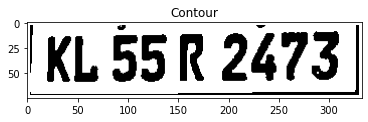

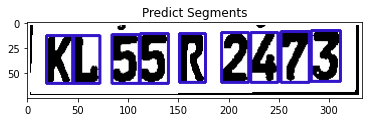

In [ ]:
char=segment_characters(cropped)

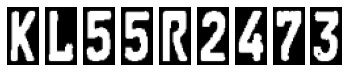

In [ ]:
for i in range(len(char)):
    plt.subplot(1, len(char), i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')
plt.show()

# YoloV4 with CNN

In [ ]:
import numpy as np
import pandas as pd
import cv2
import imutils
import matplotlib.pyplot as plt
import math
import tensorflow as tf
from sklearn.metrics import f1_score 
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D
from IPython.display import Image
import argparse
import os

In [ ]:
labels=pd.read_excel('test_dataset/labels.xlsx')
labels['ID']=labels['ID'].map(str)
labels

ID       NUMBER
0      1    KL55R2473
1      2  GJW115A1138
2      3    KL16J3636
3      4   MH20EE7598
4      5      PJJ1L76
..   ...          ...
181  182      DHF5B15
182  183      DBJ5R59
183  184      LVY8X45
184  185      YYD6B61
185  186      CHI4A30

[186 rows x 2 columns]

In [ ]:
def dist(x1, x2, y1, y2):
    return ((x1-x2)**2+(y1-y2)**2)**0.5

In [ ]:
# Load names of classes
classesFile = "yolo_utils/classes.names";

In [ ]:
# Give the configuration and weight files for the model and load the network using them.
modelConfiguration = "yolo_utils/darknet-yolov4.cfg";
modelWeights = "yolo_utils/yolov4.weights";

In [ ]:
confThreshold = 0.5  #Confidence threshold
nmsThreshold = 0.4  #Non-maximum suppression threshold

inpWidth = 416     #Width of network's input image
inpHeight = 416     #Height of network's input image

classes = None
with open(classesFile, 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')

net = cv2.dnn.readNetFromDarknet(modelConfiguration, modelWeights)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

In [ ]:
# Get the names of the output layers
def getOutputsNames(net):
    # Get the names of all the layers in the network
    layersNames = net.getLayerNames()
    # Get the names of the output layers, i.e. the layers with unconnected outputs
    return [layersNames[i[0] - 1] for i in net.getUnconnectedOutLayers()]

In [ ]:
# Remove the bounding boxes with low confidence using non-maxima suppression
def postprocess(frame, outs):
    frameHeight = frame.shape[0]
    frameWidth = frame.shape[1]
    
    # Scan through all the bounding boxes output from the network and keep only the
    # ones with high confidence scores. Assign the box's class label as the class with the highest score.
    classIds = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            #if detection[4]>0.001:
            scores = detection[5:]
            classId = np.argmax(scores)
            #if scores[classId]>confThreshold:
            confidence = scores[classId]
            if confidence > confThreshold:
                center_x = int(detection[0] * frameWidth)
                center_y = int(detection[1] * frameHeight)
                width = int(detection[2] * frameWidth)
                height = int(detection[3] * frameHeight)
                left = int(center_x - width / 2)
                top = int(center_y - height / 2)
                classIds.append(classId)
                confidences.append(float(confidence))
                boxes.append([left, top, width, height])

    # Perform non maximum suppression to eliminate redundant overlapping boxes with
    # lower confidences.
    cropped=None
    indices = cv2.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)
    for i in indices:
        i = i[0]
        box = boxes[i]
        left = box[0]
        top = box[1]
        width = box[2]
        height = box[3]
        
        # calculate bottom and right
        bottom = top + height
        right = left + width
        
        #crop the plate out
        cropped = frame[top:bottom, left:right].copy()
    if cropped is not None:
        return cropped

In [ ]:
# Draw the predicted bounding box
def drawPred(classId, conf, left, top, right, bottom, frame):
    # Draw a bounding box.
    cv2.rectangle(frame, (left, top), (right, bottom), (0, 255, 0), 3)

    label = '%.2f' % conf

    # Get the label for the class name and its confidence
    if classes:
        assert(classId < len(classes))
        label = '%s:%s' % (classes[classId], label)

    #Display the label at the top of the bounding box
    labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    top = max(top, labelSize[1])
    cv2.rectangle(frame, (left, top - round(1.5*labelSize[1])), (left + round(1.5*labelSize[0]), top + baseLine), (0, 0, 255), cv2.FILLED)
    cv2.putText(frame, label, (left, top), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0,0,0), 2)

In [ ]:
# Match contours to license plate or character template
def find_contours(dimensions, img) :

    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]
    
    # Check largest 5 or  15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]
    
    ii = cv2.imread('contour.jpg')
    
    x_cntr_list = []
    target_contours = []
    img_res = []
    for cntr in cntrs :
        # detects contour in binary image and returns the coordinates of rectangle enclosing it
        intX, intY, intWidth, intHeight = cv2.boundingRect(cntr)
        
        # checking the dimensions of the contour to filter out the characters by contour's size
        if intWidth > lower_width and intWidth < upper_width and intHeight > lower_height and intHeight < upper_height :
            x_cntr_list.append(intX) #stores the x coordinate of the character's contour, to used later for indexing the contours

            char_copy = np.zeros((44,24))
            # extracting each character using the enclosing rectangle's coordinates.
            char = img[intY:intY+intHeight, intX:intX+intWidth]
            char = cv2.resize(char, (20, 40))
            
            cv2.rectangle(ii, (intX,intY), (intWidth+intX, intY+intHeight), (50,21,200), 2)

            # Make result formatted for classification: invert colors
            char = cv2.subtract(255, char)

            # Resize the image to 24x44 with black border
            char_copy[2:42, 2:22] = char
            char_copy[0:2, :] = 0
            char_copy[:, 0:2] = 0
            char_copy[42:44, :] = 0
            char_copy[:, 22:24] = 0

            img_res.append(char_copy) # List that stores the character's binary image (unsorted)

    # arbitrary function that stores sorted list of character indeces
    indices = sorted(range(len(x_cntr_list)), key=lambda k: x_cntr_list[k])
    img_res_copy = []
    for idx in indices:
        img_res_copy.append(img_res[idx])# stores character images according to their index
    img_res = np.array(img_res_copy)

    return img_res

In [ ]:
# Find characters in the resulting images
def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255

    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/6,
                       LP_WIDTH/2,
                       LP_HEIGHT/10,
                       2*LP_HEIGHT/3]
    cv2.imwrite('contour.jpg',img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)

    return char_list

Loding CNN 

In [ ]:
# Create a new model instance
loaded_model = Sequential()
loaded_model.add(Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(Conv2D(32, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(Conv2D(64, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(Conv2D(64, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))
loaded_model.add(MaxPooling2D(pool_size=(4, 4)))
loaded_model.add(Dropout(0.4))
loaded_model.add(Flatten())
loaded_model.add(Dense(128, activation='relu'))
loaded_model.add(Dense(36, activation='softmax'))

# Restore the weights
loaded_model.load_weights('checkpoints/my_checkpoint')

In [ ]:
# Predicting the output
def fix_dimension(img): 
  new_img = np.zeros((28,28,3))
  for i in range(3):
    new_img[:,:,i] = img
  return new_img
  
def show_results(count):
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char): #iterating over the characters
        img_ = cv2.resize(ch, (28,28), interpolation=cv2.INTER_AREA)
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3) #preparing image for the model
        y_ = loaded_model.predict_classes(img)[0] #predicting the class
        character = dic[y_] #
        output.append(character) #storing the result in a list
        
    plate_number = ''.join(output)
    if plate_number==row:
        count+=1
    return count

In [ ]:
file_list=os.listdir(r"test_dataset/images")
count=0
for path in file_list:
#for entry in labels['ID']:
    input_path = 'test_dataset/images/'+path
    is_video = False
    no=path[:-4]
    row=labels['NUMBER'].where(labels['ID'] == no).dropna().values[0]
    
    cap = cv2.VideoCapture(input_path)

    outputFile = input_path + '_yolo_out_py.jpg'

    while cv2.waitKey(1) < 0:

        # get frame from the video
        hasFrame, frame = cap.read() #frame: an image object from cv2

        # Stop the program if reached end of video
        if not hasFrame:
            break

        # Create a 4D blob from a frame.
        try:
            blob = cv2.dnn.blobFromImage(frame, 1/255, (inpWidth, inpHeight), [0,0,0], 1, crop=False)
        except:
            break

        # Sets the input to the network
        net.setInput(blob)

        # Runs the forward pass to get output of the output layers
        outs = net.forward(getOutputsNames(net))

        # Remove the bounding boxes with low confidence
        cropped = postprocess(frame, outs)
        if cropped is not None:
            # Put efficiency information. The function getPerfProfile returns the overall time for inference(t) and the timings for each of the layers(in layersTimes)
            t, _ = net.getPerfProfile()
            label = 'Inference time: %.2f ms' % (t * 1000.0 / cv2.getTickFrequency())
            #cv.putText(frame, label, (0, 15), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))

            # Write the frame with the detection boxes
            if is_video:
                vid_writer.write(frame.astype(np.uint8))
            else:
                #plt.imshow(cropped)
                #plt.show()
                char=segment_characters(cropped)
                count=show_results(count)
        else:
            ####
            image = cv2.imread('test_dataset/images/'+path)
            # Resize the image - change width to 500
            image = imutils.resize(image, width=500)
            img=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # RGB to Gray scale conversion
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            # Noise removal with iterative bilateral filter(removes noise while preserving edges)
            gray = cv2.bilateralFilter(gray, 11, 17, 17)

            # Find Edges of the grayscale image
            edged = cv2.Canny(gray, 170, 200)

            # Find contours based on Edges
            cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[0]
            cnts=sorted(cnts, key = cv2.contourArea, reverse = True)[:30] #sort contours based on their area keeping minimum required area as '30' (anything smaller than this will not be considered)
            NumberPlateCnt = None #we currently have no Number plate contour

            # loop over our contours to find the best possible approximate contour of number plate
            for c in cnts:
                    peri = cv2.arcLength(c, True)
                    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
                    if len(approx) == 4:  # Select the contour with 4 corners
                        NumberPlateCnt = approx #This is our approx Number Plate Contour
                        x,y,w,h = cv2.boundingRect(c)
                        ROI = img[y:y+h, x:x+w]
                        break

            idx=0
            m=0
            if NumberPlateCnt is None:
                continue
            for i in range(4):
                if NumberPlateCnt[i][0][1]>m:
                    idx=i
                    m=NumberPlateCnt[i][0][1]
            if idx==0:
                pin=3
            else:
                pin=idx-1
            if idx==3:
                nin=0
            else:
                nin=idx+1

            p=dist(NumberPlateCnt[idx][0][0], NumberPlateCnt[pin][0][0], NumberPlateCnt[idx][0][1], NumberPlateCnt[pin][0][1])
            n=dist(NumberPlateCnt[idx][0][0], NumberPlateCnt[nin][0][0], NumberPlateCnt[idx][0][1], NumberPlateCnt[nin][0][1])

            if p>n:
                if NumberPlateCnt[pin][0][0]<NumberPlateCnt[idx][0][0]:
                    left=pin
                    right=idx
                else:
                    left=idx
                    right=pin
                d=p
            else:
                if NumberPlateCnt[nin][0][0]<NumberPlateCnt[idx][0][0]:
                    left=nin
                    right=idx
                else:
                    left=idx
                    right=nin
                d=n
            left_x=NumberPlateCnt[left][0][0]
            left_y=NumberPlateCnt[left][0][1]
            right_x=NumberPlateCnt[right][0][0]
            right_y=NumberPlateCnt[right][0][1]

            opp=right_y-left_y
            hyp=((left_x-right_x)**2+(left_y-right_y)**2)**0.5
            sin=opp/hyp
            theta=math.asin(sin)*57.2958

            image_center = tuple(np.array(ROI.shape[1::-1]) / 2)
            rot_mat = cv2.getRotationMatrix2D(image_center, theta, 1.0)
            result = cv2.warpAffine(ROI, rot_mat, ROI.shape[1::-1], flags=cv2.INTER_LINEAR)

            if opp>0:
                h=result.shape[0]-opp//2
            else:
                h=result.shape[0]+opp//2

            result=result[0:h, :]
            char=segment_characters(result)
            count=show_results(count)

print("Accuracy: "+str((count/166)*100)+"%")

Accuracy: 66.26506024096386%


# **GAN**

In [2]:
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import numpy as np 
import pandas as pd
import os
from time import perf_counter
import cv2
import tensorflow as tf

In [3]:
dataFrame = {
    'image' : [],
    'box'   : [],
}

In [4]:
# A composite function for loading and drawing box
# around license plate 
def Reader(path, annotPath, size = 256, isPlot = False, showTime = False):
    
    start = perf_counter()
    img = plt.imread(path)
    img =  np.array (img[:, :, 0:3])
    
    if isPlot:
        plt.subplot(1, 2, 1)
        plt.imshow(img)
   
    # parsing html
    with open(annotPath, 'r') as f: 
        data = f.read() 
    
    Bs = BeautifulSoup(data, "xml")
    xMax = int (Bs.find('xmax').text)
    xMin = int (Bs.find('xmin').text)
    yMax = int (Bs.find('ymax').text)
    yMin = int (Bs.find('ymin').text)
    
    # storing data
    dataFrame['image'].append  ( cv2.resize(img, (size, size)))
    # drawing box
    imgBoxed = cv2.rectangle(img, (xMin, yMin), (xMax, yMax), (0 ,255, 0), 2)
    # storing data into frame
    dataFrame['box'].append (cv2.resize(imgBoxed, (size, size)))
    
    if isPlot:
        plt.subplot(1, 2, 2)
        plt.imshow(cv2.resize(imgBoxed, (size,size)))
    
    if showTime:
        return perf_counter() - start

In [5]:
def Generative(imageDir, annotDir):
    start = perf_counter()
    imageNames = os.listdir(imageDir)
    
    for mem in imageNames:
        path = imageDir + '/' + mem
        annotPath = annotDir + '/' + mem.split('.')[0] + '.xml'
        Reader(path, annotPath)
       
    return perf_counter() - start

In [6]:
Generative('/content/drive/MyDrive/archive/images' ,'/content/drive/MyDrive/archive/annotations')

112.12398212

In [7]:
# defining autoencoder model
def Conv2dBlock(inputTensor, numFilters, kernelSize = 3, doBatchNorm = True):
    #first Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (inputTensor)
    
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x =tf.keras.layers.Activation('relu')(x)
    
    #Second Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (x)
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x = tf.keras.layers.Activation('relu')(x)
    
    return x


def discrimination(inputImage, numFilters = 16, droupouts = 0.1, doBatchNorm = True):
    # defining encoder Path
    c1 = Conv2dBlock(inputImage, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(droupouts)(p1)
    
    c2 = Conv2dBlock(p1, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(droupouts)(p2)
    
    c3 = Conv2dBlock(p2, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(droupouts)(p3)
    
    c4 = Conv2dBlock(p3, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(droupouts)(p4)
    
    c5 = Conv2dBlock(p4, numFilters * 16, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    # defining decoder path
    u6 = tf.keras.layers.Conv2DTranspose(numFilters*8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(droupouts)(u6)
    c6 = Conv2dBlock(u6, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u7 = tf.keras.layers.Conv2DTranspose(numFilters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(droupouts)(u7)
    c7 = Conv2dBlock(u7, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u8 = tf.keras.layers.Conv2DTranspose(numFilters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(droupouts)(u8)
    c8 = Conv2dBlock(u8, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u9 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(droupouts)(u9)
    c9 = Conv2dBlock(u9, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    output = tf.keras.layers.Conv2D(3, (1, 1), activation = 'softmax')(c9)
    model = tf.keras.Model(inputs = [inputImage], outputs = [output])
    return model

In [8]:
## instanctiating model
inputs = tf.keras.layers.Input((256, 256, 3))
myTransformer = discrimination(inputs, droupouts= 0.07)
myTransformer.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'] )

In [10]:
retVal = myTransformer.fit(np.array(dataFrame['image']), np.array(dataFrame['box']), epochs = 5, verbose = 0)

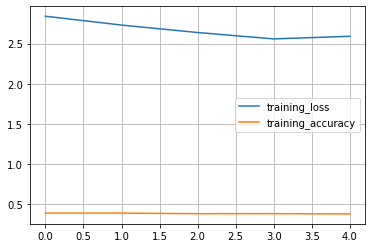

In [11]:
plt.plot(retVal.history['loss'], label = 'training_loss')
plt.plot(retVal.history['accuracy'], label = 'training_accuracy')
plt.legend()
plt.grid(True)

In [12]:
## function for getting 16 predictions
def predict16 (valMap, model, shape = 256):
    ## getting and proccessing val data
    img = valMap['image']
    mask = valMap['box']
    mask = mask[0:16]
    
    imgProc = img [0:16]
    imgProc = np.array(img)
    
    predictions = model.predict(imgProc)
    for i in range(len(predictions)):
        predictions[i] = cv2.merge((predictions[i,:,:,0],predictions[i,:,:,1],predictions[i,:,:,2]))
    
    return predictions, imgProc, mask


def Plotter(img, predMask, groundTruth):
    plt.figure(figsize=(20,10))
    
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title('original Image')
    
    ## Adding Image sharpening step here
    ## it is a sharpening filter
    filter = np.array([[-1, -1, -1], [-1, 8.99, -1], [-1, -1, -1]]) 
    imgSharpen = cv2.filter2D(predMask,-1,filter)
    
    plt.subplot(1,3,2)
    plt.imshow(imgSharpen)
    plt.title('Predicted Box position')
    
    plt.subplot(1,3,3)
    plt.imshow(groundTruth)
    plt.title('actual box Position')

In [13]:
sixteenPrediction, actuals, masks = predict16(dataFrame, myTransformer)

14/14 [==============================] - 78s 5s/step


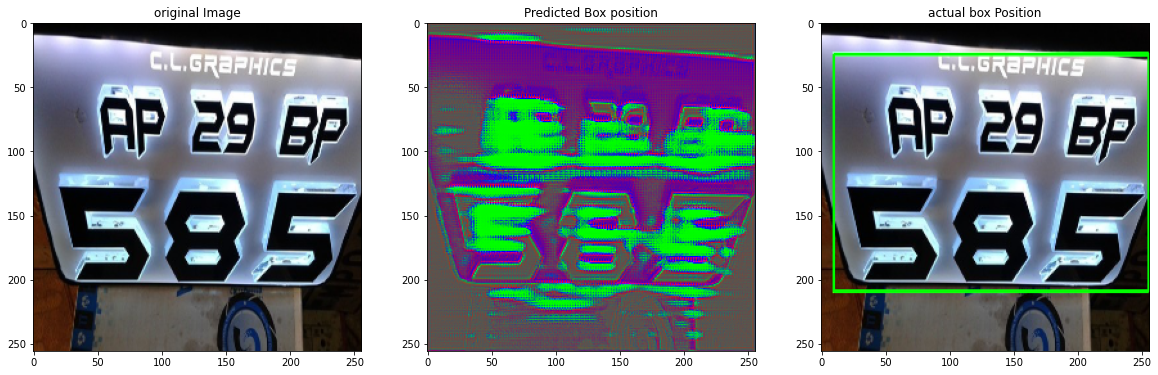

In [14]:
Plotter(actuals[1], sixteenPrediction[1], masks[1])

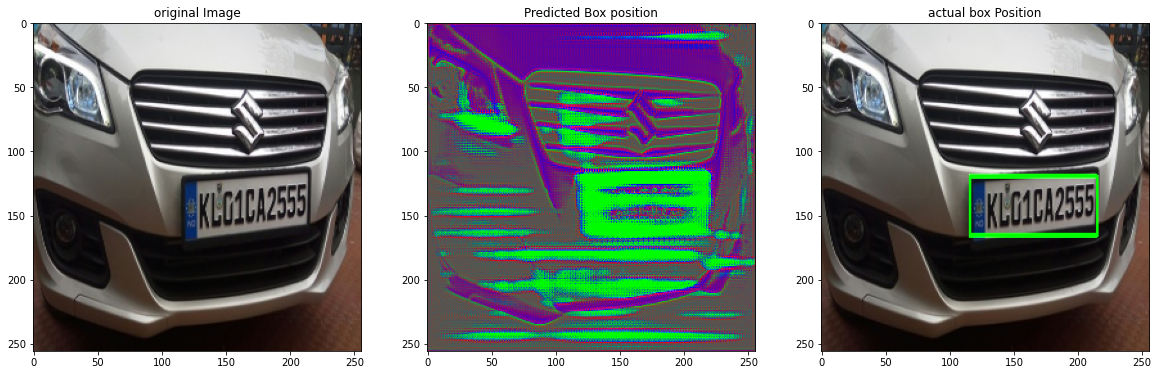

In [15]:
Plotter(actuals[4], sixteenPrediction[4], masks[4])

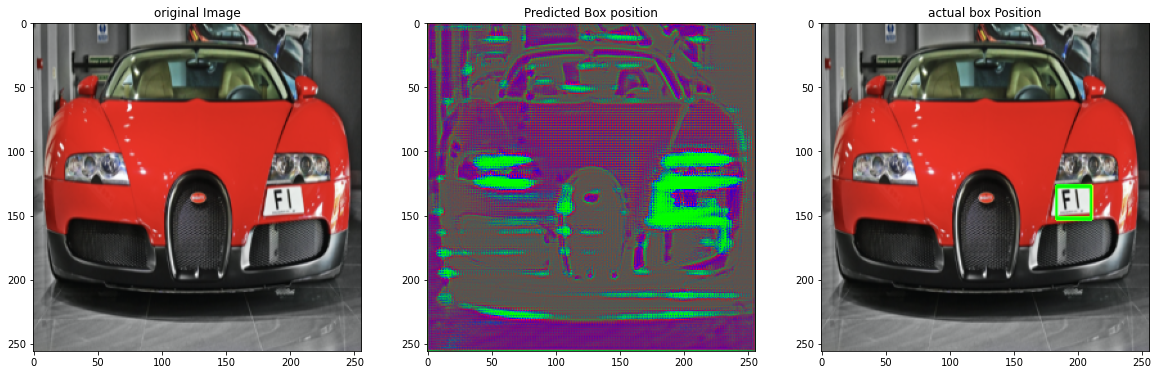

In [16]:
Plotter(actuals[5], sixteenPrediction[5], masks[5])

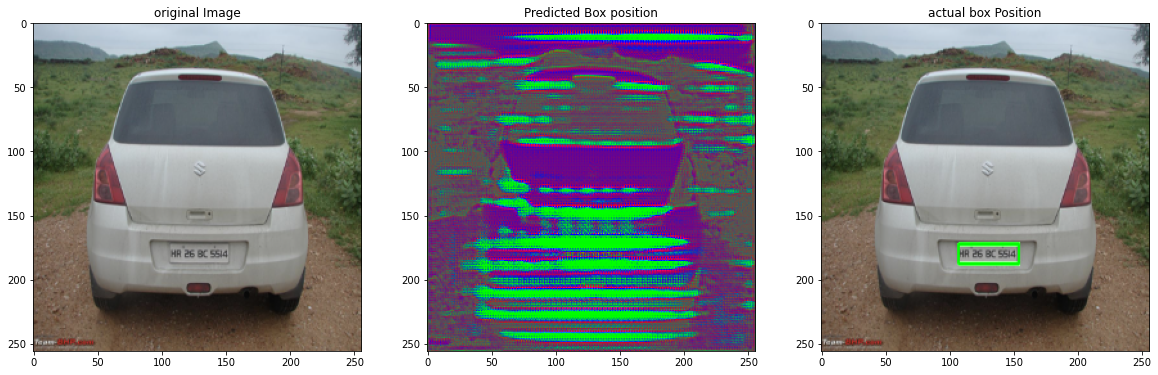

In [17]:
Plotter(actuals[7], sixteenPrediction[7], masks[7])

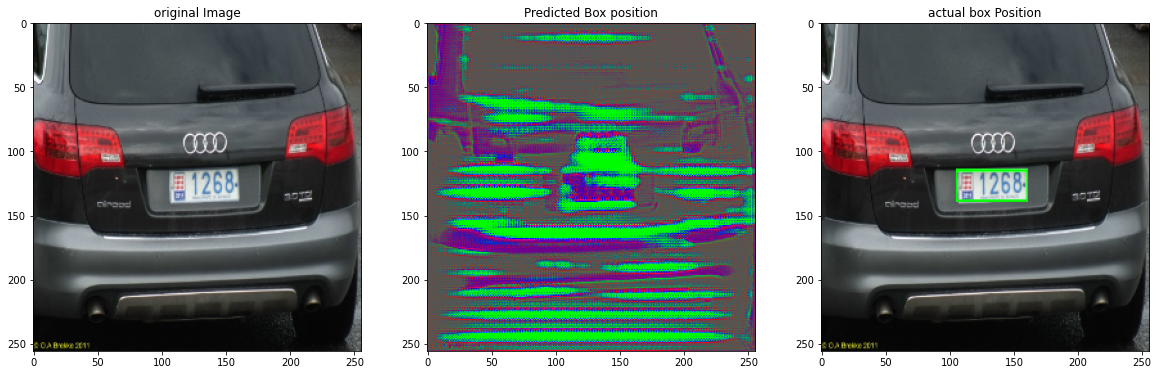

In [18]:
Plotter(actuals[11], sixteenPrediction[11], masks[11])